<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Building a CNN: Filters, Layers, Flattening, and Receptive Field**


Estimated time needed: **45** minutes


Now that you have an idea of how filters can be applied to a channel in different ways via padding, stride, and activation functions, let's proceed to the next level. What do we do when there are multiple filters for the channel or multiple layers of filters ? Like a regular neural network with multiple neurons, in a CNN you can have  multiple convolution layers. In addition, you can have multiple filters or kernels per layer. In this lab, we will see how a CNN processes multiple channels, filters, and layers, and flatten the output so it can be used as input to a regular neural network.


## **Table of Contents**

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="https://#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="https://#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="https://#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>
    </li>
    <li>
        <a href="https://#Deeper-Networks-and-the-Receptive-Field:-Relating-Input-to-Output">Deeper Networks and the Receptive Field: Relating Input to Output</a>
        <ol>
            <li><a href="https://#What-is-it-for?">What is it for?</a></li>
            <li><a href="https://#What-affects-receptive-field?">What affects receptive field?</a></li>
            <li><a href="https://#Model-1:-No-Stride">Model 1: No Stride</a></li>
            <li><a href="https://#Model-2:-Increased-Stride">Model 2: Increased Stride</a></li>
            <li><a href="https://#Model-3:-Increased-Layers">Model 3: Increased Layers</a></li>
            <li><a href="https://#Visualizing-the-Outputs">Visualizing the Outputs</a></li>
        </ol>
    </li>
    <li><a href="https://#Varied-Input-Output-Relationships">Varied Input-Output Relationships</a></li>
        <ol>
            <li><a href="https://#Import-the-Data-and-Define-Filters">Import the Data and Define Filters</a></li>
            <li><a href="https://#Single-Input-Multiple-Outputs">Single Input, Multiple Outputs</a></li>
            <li><a href="https://#Multiple-Inputs-Single-Output">Multiple Inputs, Single Output</a></li>
            <li><a href="https://#Multiple-Inputs-Multiple-Outputs">Multiple Inputs, Multiple Outputs</a></li>
        </ol>
    <li><a href="https://#Deeper-CNNs">Deeper CNNs</a></li>
        <ol>
            <li><a href="https://#Why-do-we-want-multiple-layers?">Why do we want multiple layers?</a></li>
            <li><a href="https://#Example:-Preparing-a-CNN-for-Flower-Classification">Example: Preparing a CNN for Flower Classification</a></li>
            <li><a href="https://#Flattening">Flattening</a></li>
            <li><a href="https://#Dense-Layers">Dense Layers</a></li>
        </ol>
</ol>


## Objectives

After completing this lab you will be able to:

*   Understand the relationship between features and effective receptive field size
*   Apply filters on inputs of varying depth and calculate output size
*   Build CNNs with greater depth to learn more features and prepare for image classification


***


## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the folowing code cell.


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

The following required libraries are **not** pre-installed in the Skills Network Labs environment. **You will need to run the following cell** to install them:


### Importing Required Libraries

*We recommend you import all required libraries in one place (here):*


In [1]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass


import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # tensorflow INFO and WARNING messages are not printed

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

import glob
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

### Defining Helper Functions


In [3]:
def calc_rf(model):
    # Initialize an array storing all the layers' receptive field sizes and set layer 0 (input) RF to 1
    num_layers = len(model.layers)
    rf_arr = np.empty(num_layers+1, dtype=int)
    rf_arr[0] = 1
    # Initialize an array storing all the layers' jump sizes and set layer 0 (input) jump to 1
    j_arr = np.empty(num_layers+1, dtype=int)
    j_arr[0] = 1

    for i in range(num_layers):
        layer = model.layers[i]
        k = layer.kernel_size[0]
        s = layer.strides[0]
        j_in = j_arr[i]
        j_out = j_in * s
        r_out = rf_arr[i] + (k - 1) * j_in
        j_arr[i+1] = j_out
        rf_arr[i+1] = r_out
        print("Layer {}: {} \n Jump Size: {}\n Effective Receptive Field Size: {}".format(i+1, layer.name, j_arr[i+1], rf_arr[i+1]))
        print("------")

## Deeper Networks and the Receptive Field: Relating Input to Output


Why should we add more layers to a CNN? It turns out that CNNs behave like the human eye. When we look at something, each of the million neurons in our eye is responsible for observing a specific section of the view. Similarly in a CNN, each output feature is responsible for gathering information in a region of the input. This region is equal to the size of the kernel that it is convolved with to get a single value in the output. We call this region the feature's **receptive field**.

As more layers are added to the network, we also use the term **“effective receptive field”** (ERF) to refer to the pixels in the first input, the original image, that was indirectly convolved to attain a feature in a subsequent layer. Hence, it makes sense that ERF size increases with layers as each feature is generated from a convolution of its input, each pixel of which is a convolution of the previous layer, and so on.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/rf_fixed.png" width="600" alt="visual showing receptive field with fixed map size"  />
<center>

Image credits to [Dang Ha The Hien](https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)


In the visual above, the shaded region that surrounds the center feature in the top two layers is their ERF. You can see that a feature in the green layer has an ERF size of 3x3, meaning that it observes those 9 pixels in the input image (blue). In the yellow layer, this has increased - one feature is responsible for viewing a 7x7 region in the input. Notably, the center feature's ERF covers almost all of the input pixels!


We can also use a formula to calculate what the effective receptive field size is:

$$r_{out} = r_{in} + (k - 1)*j_{in}$$

*   $r_{out}$: ERF width/height of an output feature
*   $r_{in}$: ERF width/height of an input feature
*   $k$: convolution kernel width/height
*   $j_{in}$: distance between two consecutive features in the input
*   Note: $j_{out} = j_{in} * s$ for $s$ = stride size

As an example, let's apply convolution to the input image (blue) above with k=3 and calculate the ERF. In the input, each feature's ERF size is 1 because it only observes itself. The distance between two features is 1. Hence, in our first layer output (green), the ERF size is 1 + (3-1)*1 = 3.


### What is it for?


Receptive field describes how much information is learned by each layer of the network. The bigger the receptive field size, the bigger “view” each feature has. Let’s think back to the eye analogy. If a neuron is only able to observe a small region, then 1) one neuron might not have enough information to detect a bigger object, and 2) we need more neurons to attain a complete view. In CNN tasks such as object detection and image segmentation, this is detrimental; features won't be able to learn to recognize a characteristic spanning a bigger input region.


### What affects receptive field?


Ideally, we want each output feature to have a big receptive field so that crucial information is captured and that relevant features can be completely recognized. Think of it like a camera - if you zoom in too much, the lens can only see parts of an object, which could prevent you from detecting what it is. Things that impact receptive field size include:

*   Number of convolution layers: making a deeper network increases field size linearly by kernel size.
*   Stride: as a method of sub-sampling, the higher the stride value, the fewer input pixels shared between neighboring features, the bigger the receptive field as we add more layers.
*   Pooling: this is also a way of sub-sampling that increases the size multiplicatively. It causes resolution loss as the relationship between the original input features isn't fully retained.
*   Dilation rate: introduces spaces in between kernel values such that they aren't applied to adjacent samples. Increases size exponentially without loss of resolution like sub-sampling techniques (not covered).


Let's see an example of how stride and adding layers affect the receptive field! First let's download the image:


In [4]:
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/RF_dot.png" -P ./data/

--2023-10-11 20:06:10--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/RF_dot.png
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30331 (30K) [image/png]
Saving to: ‘./data/RF_dot.png’

RF_dot.png          100%[===================>]  29.62K   126KB/s    in 0.2s    

2023-10-11 20:06:13 (126 KB/s) - ‘./data/RF_dot.png’ saved [30331/30331]



We load the image:


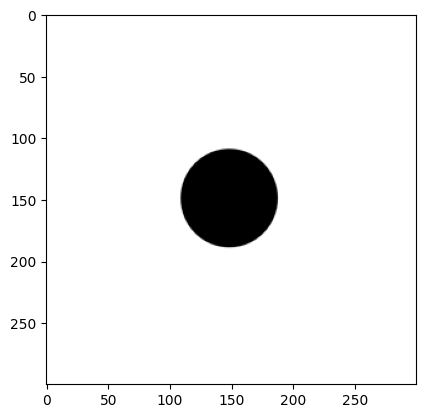

In [6]:
img_width = 300
img_height = 300

dot = PIL.Image.open("./data/RF_dot.png")
dot = ImageOps.grayscale(dot)
# dot = PIL.ImageOps.invert(dot)
dot = dot.resize((img_width, img_height))
plt.imshow(dot, cmap="gray")
plt.show()

Below, we define the kernel and bias weights. For this section, we chose to use the average kernel, which takes the mean of the pixels. Also, we will use the helper function `calc_rf` defined previously to determine the ERF size of a feature in each layer.


In [7]:
kernel = (1/9)*np.ones((3,3,1,1))
b = np.array([0.0])

In [9]:
kernel, b

(array([[[[0.11111111]],
 
         [[0.11111111]],
 
         [[0.11111111]]],
 
 
        [[[0.11111111]],
 
         [[0.11111111]],
 
         [[0.11111111]]],
 
 
        [[[0.11111111]],
 
         [[0.11111111]],
 
         [[0.11111111]]]]),
 array([0.]))

### Model 1: No Stride

To begin, we'll check what the output looks like when we have a model with no stride. With the parameters specified, our ERF should be 3 for the output.


In [10]:
# Construct the model with no stride
model1 = Sequential()

model1.add(Conv2D(input_shape = (img_width, img_height, 1),
                 filters=1,
                 kernel_size=(3,3)
                 ))

model1.layers[0].set_weights([kernel,b])

calc_rf(model1)

Layer 1: conv2d 
 Jump Size: 1
 Effective Receptive Field Size: 3
------


### Model 2: Increased Stride


Here we set the `strides` to 2 for the 2nd model.


In [11]:
# Construct the model with stride = 2
model2 = Sequential()

model2.add(Conv2D(input_shape = (img_width, img_height, 1),
                 filters=1,
                 kernel_size=(3,3),
                 padding='same',
                 strides=2
                 ))

model2.layers[0].set_weights([kernel,b])

calc_rf(model2)

Layer 1: conv2d_1 
 Jump Size: 2
 Effective Receptive Field Size: 3
------


Even with increased stride size, the ERF size is still 3. This is expected because our output's ERF size depends on the kernel and the input's RF and jump, all of which haven't changed between model 1 and 2.


### Model 3: Increased Layers


Lets see what happens with we increased the number of layers:


In [12]:
# Construct the model with multiple layers
model3 = Sequential()

model3.add(Conv2D(input_shape = (img_width, img_height, 1),
                 filters=1,
                 kernel_size=(3,3)
                 ))
model3.add(Conv2D(filters=1,
                 kernel_size=(3,3),
                 strides=4
                 ))
model3.add(Conv2D(filters=1,
                 kernel_size=(3,3),
                 strides=5
                 ))

model3.layers[0].set_weights([kernel,b])
model3.layers[1].set_weights([kernel,b])
model3.layers[2].set_weights([kernel,b])

calc_rf(model3)

Layer 1: conv2d_2 
 Jump Size: 1
 Effective Receptive Field Size: 3
------
Layer 2: conv2d_3 
 Jump Size: 4
 Effective Receptive Field Size: 5
------
Layer 3: conv2d_4 
 Jump Size: 20
 Effective Receptive Field Size: 13
------


After adding more layers to the model, we clearly see the ERF size for each feature increased in subsequent layers. In particular, the ERF of layer 3 is significantly bigger than it would have been if there's no stride.


### Visualizing the Outputs


Let's compare the results to of the models:


1/1 [==============================] - 0s 27ms/step


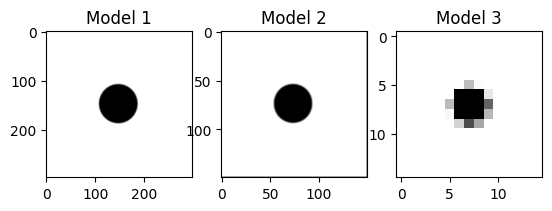

In [13]:
models = [model1, model2, model3]
dot_tensor = np.array(dot).reshape((1,img_width,img_height,1))
fig, ax = plt.subplots(1,len(models))

for i in range(len(models)):
    plt.subplot(1,len(models),i+1)
    output = models[i].predict(dot_tensor)
    output = output.reshape(output.shape[1],output.shape[2])
    plt.title("Model {}".format(i+1))
    plt.imshow(output, cmap='gray')

As we increase the receptive field the subsequent images get smaller and smaller, but we can still make out the shape. This also decreased the number of parameters needed in the model.


## Varied Input-Output Relationships


We previously only dealt with applying one kernel on one channel at a time, but that is quite inefficient to do since we often have access to multichannel (colored) image inputs, whose information can be learned jointly. Moreover, the convolutional layers are analogous to the hidden neurons in a neural network, and like a regular neural network, adding more neurons will improve results. Next, we will take a look at how increasing the number of channels can increase the information extracted.


Consider the following image:


In [14]:
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/channel_image.jpg" -P "./data/"

--2023-10-11 20:13:41--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/channel_image.jpg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37209 (36K) [image/jpeg]
Saving to: ‘./data/channel_image.jpg’

channel_image.jpg   100%[===================>]  36.34K   152KB/s    in 0.2s    

2023-10-11 20:13:43 (152 KB/s) - ‘./data/channel_image.jpg’ saved [37209/37209]



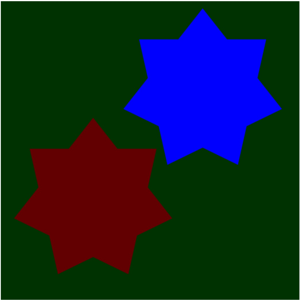

In [16]:
img_width = 300
img_height = 300

image = PIL.Image.open("./data/channel_image.jpg").resize((img_width, img_height))
image

First, we define two filters we will use throughout the examples. The first filter is an edge kernel, which you have seen previously in the lab on padding, strides, and activation. This kernel helps us detect edges in the image. The second filter is a kernel that sharpens the image through creating greater contrast. Note that usually, in CNN, we would let the network learn the best filters automatically instead of defining them.


In [17]:
def edge_grad(shape, dtype=None):
    grad = np.array([
        [-1, -1, -1],
        [-1, 8, -1],
        [-1, -1, -1]
        ]).reshape(shape)

    return grad

def sharpen_grad(shape, dtype=None):
    grad = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ]).reshape(shape)

    return grad

### Single Input, Multiple Outputs


Based on what you learned from past labs, you know how to apply a filter on a black and white image, so let's start with that. However, this time we will apply multiple filters on the grayscale image.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/SingleInMultiOut.png" width="600" alt="single input multiple output calculation"  />
<center>


The visual above, shows how outputs are calculated when there is a single channel but multiple filters. We can see that the depth of the output (number of channels it has) corresponds to the number of filters applied on the input.


Here's a formula for calculating the width/height of one output channel:
$$n\_{out} = \frac{n\_{in} + 2p - k}{s} + 1$$

*   $n\_{out}$: width/height of output map
*   $n\_{in}$: width/height of input map
*   $p$: convolution padding size
*   $k$: convolution kernel width/height
*   $s$: convolution stride size


As a first step, we convert the image to grayscale such that we work with a single channel as our input for now. Here, when the image is converted to grayscale, the stars are not visible anymore due to their RGB values being converted to a singular value representing brightness, which raises the concern of whether the filters will be able to detect any features.


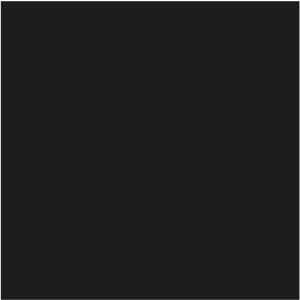

In [18]:
gray = ImageOps.grayscale(image)
img_tensor = np.array(gray).reshape((1, img_width, img_height, 1)) # Convert to a tensor for model prediction
gray

Next, we define the desired kernels. Note here that the kernel takes on the size 3x3x1x2. This means that there are 2 filters, each with the dimension 3x3x1, where 1 represents the number of channels and 3x3 is the 2D kernel size. This shape is required because we are performing both convolutions in a single layer. The bias, set to 0 for both convolutions on the input, is represented by the variable `b`.


In [21]:
kernels = np.array([sharpen_grad((3,3,1,1)), edge_grad((3,3,1,1))])
kernels = kernels.reshape((3,3,1,2))
b = np.array([np.array([0.0]),np.array([0.0])]).reshape(2,)

Here, we define the Sequential model, adding one convolutional layer with 2 filters of size 3x3. After this, we specify the kernels and biases by the function `set_weights`. To see more information about the model built, use `summary()`.


In [22]:
model = Sequential()

model.add(Conv2D(filters = 2,
                 kernel_size = (3, 3),
                 padding='same',
                 input_shape = (img_width, img_height, 1)))

model.set_weights([kernels,b])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 300, 300, 2)       20        
                                                                 
Total params: 20 (80.00 Byte)
Trainable params: 20 (80.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In order to see how each filter is applied on the input, we use an additional model that specifies the desired output when given input from our previous model.


In [23]:
layer_outputs = [layer.output for layer in model.layers] # Extracts the outputs of the layer
activation_model = Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5_input (InputLayer  [(None, 300, 300, 1)]     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 300, 300, 2)       20        
                                                                 
Total params: 20 (80.00 Byte)
Trainable params: 20 (80.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now that we have set up the model structure, we feed the image tensor as input to the activation model to separate the outputs from individual kernels.


In [24]:
activations = activation_model.predict(img_tensor) # Obtain the outputs (activations) from our model

1/1 [==============================] - 0s 24ms/step


In [25]:
filter_outputs = activations[0]  # Extract the outputs from the first (in this case, the only) layer of the model
print(filter_outputs.shape)

(300, 300, 2)


The output shape confirms that the model correctly applied the two filters on the input as the output depth is 2 - one dimension for each filter. Using the formula above, we also know that the width and height are (1)\*300+2(1)-3 + 1 = 300. Since each filter output is a tensor, we can also display their weights by directly indexing the object:


In [26]:
# Display weights of the first filter of this layer
filter_outputs[:,:,0]

array([[-553., -632., -496., ..., -489., -586., -253.],
       [ 947.,  925., 1110., ..., 1117.,  890., -173.],
       [ 145.,   98.,  281., ...,  274.,  525., -180.],
       ...,
       [-101., -151.,   33., ...,   27.,  414., -175.],
       [-153., -252., -106., ..., -108.,  302., -243.],
       [  73.,   57.,   61., ...,   46.,  586.,    0.]], dtype=float32)

We can also visualize the outputs from each convolution:


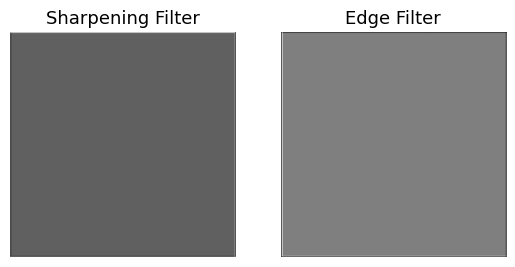

In [27]:
# Display the filter outputs
names = ["Sharpening Filter", "Edge Filter"]
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(filter_outputs[:,:,i], cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]}", fontsize=13)

We see that given a grayscale image in which the shapes blended in completely with the background, the sharpening and edge filters can't detect any features that were apparent in the colored image.


### Multiple Inputs, Single Output


So, what if we used a colored image instead? Will the network be better at sharpening the image? Before moving onto utilizing multiple filters, let's see how the output is calculated when we have one filter applied on multiple channels, such as RGB.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/MultiInSingleOut.png" width="600" alt="multiple input single output calculation"  />
<center>


How a filter is applied on multi-channel input is quite similar to the single channel case. What's different is that now, the depth of the filter will correspond to the number of input channels, so one 2D kernel is designated for one channel. The convolved result for each channel is then added together to form a single output channel.


#### Exercise: Reshape the Image


In [28]:
# Using the RGB image from before, convert it to a numpy array
# and reshape it to be 300x300x3, where 3 is for the three channels.
# WRITE YOUR CODE HERE
img_tensor = np.array(image).reshape((1, img_width, img_height, 3))

<details><summary>Solution</summary>
    <code>img_tensor = np.array(image).reshape((1, img_width, img_height, 3))</code>
</details>


Again, we define the filter we hope to use. In this case, the kernel is of shape 3x3x3x1 because we want one 3x3 filter for each of the 3 input channels. Note that these three filters take on the same value since we want to apply the same convolution on all the channels. With one filter involved for convolution, we specify one bias value.


In [29]:
kernel = np.array([sharpen_grad((3,3,1,1)), sharpen_grad((3,3,1,1)), sharpen_grad((3,3,1,1))])
kernel = kernel.reshape((3,3,3,1))
b = np.array([0.0])

In [30]:
model = Sequential()

model.add(Conv2D(filters = 1,
                 kernel_size = (3, 3),
                 padding='same',
                 input_shape = (img_width, img_height, 3)))

model.set_weights([kernel,b])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 300, 300, 1)       28        
                                                                 
Total params: 28 (112.00 Byte)
Trainable params: 28 (112.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The output shape for the layer can also be seen in the model summary above. It matches our expectations based on the padding, stride, kernel size, and number of kernels. Again, we can visualize the output result. Since we only have a single filter, we don't need an additional model for separating out the filter outputs. However, we do need to reshape the predicted output into 2D to be able to plot it.


In [31]:
output = model.predict(img_tensor)
output = output.reshape((img_width, img_height))

1/1 [==============================] - 0s 25ms/step


In this case, `output` directly shows us the result of applying a filter on the multichannel input.


In [32]:
# View values of the output tensor
output

array([[1097.,  292.,  413., ...,  433.,  309.,  987.],
       [1704.,  268.,  541., ...,  567.,  296., 1472.],
       [1808.,   -3.,  433., ...,  464.,   52., 1454.],
       ...,
       [1837.,  -56.,  407., ...,  454.,   10., 1436.],
       [1813.,   -9.,  441., ...,  470.,   55., 1450.],
       [1201.,    7.,  303., ...,  315.,   47.,  971.]], dtype=float32)

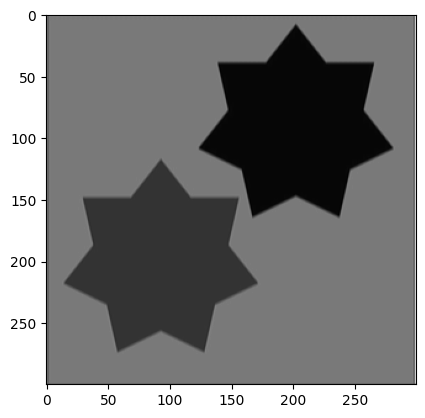

In [33]:
plt.imshow(output, cmap='gray')

It is evident here that applying a single filter on the colored image already performs better than applying two filters on the grayscale. You can see the stars now!


### Multiple Inputs, Multiple Outputs


Now for the most complex relationship -  applying multiple filters on multichannel inputs all at once. How is convolution performed, and what would the output look like? Combining knowledge from the previous two subsections, you can probably guess how we calculate the output based on multichannel inputs with multiple filters. Each output channel is calculated the same way as the "Multiple Inputs, Single Output" case. The number of output channels corresponds to the number of filters applied.


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/images/MultiInMultiOut.png" width="600" alt="multiple input multiple output calculation"  />
<center>


It is evident in the visual above that the number of output channels correspond to the number of filters we have, and each channel is the summation of convolution on the input channels for a single kernel. Let's apply the method to a color image.


In [34]:
img_tensor = np.array(image).reshape((1, img_width, img_height, 3))

We will take our color image and apply the filters to get two outputs. Here, we have 3 input channels x 2 outputs, meaning that we need 6 filter channels total, 3 for each filter. We define the filter here:


In [35]:
kernel = np.zeros((3,3,3,2))

kernel[0] = np.dstack([sharpen_grad((3,3,1)),edge_grad((3,3,1))])
kernel[1] = np.dstack([sharpen_grad((3,3,1)),edge_grad((3,3,1))])
kernel[2] = np.dstack([sharpen_grad((3,3,1)),edge_grad((3,3,1))])

kernel = kernel.reshape((3,3,3,2))

#### Exercise: Define biases

If we have one bias per operation on the input, what does our bias object look like?  Set the bias to 0.


In [36]:
# WRITE YOUR CODE HERE
b = np.array([np.array([0.0]),np.array([0.0])]).reshape(2,)

<details><summary>Solution</summary>
    <code>b = np.array([np.array([0.0]),np.array([0.0])]).reshape(2,)</code>
</details>


We proceed to define the model:


In [37]:
model = Sequential()

model.add(Conv2D(filters = 2,
                 kernel_size = (3, 3),
                 padding='same',
                 input_shape = (img_width, img_height, 3)))

model.set_weights([kernel,b])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 300, 300, 2)       56        
                                                                 
Total params: 56 (224.00 Byte)
Trainable params: 56 (224.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We assign the the pre-made filters:


In [38]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
filter_outputs = activations[0]

1/1 [==============================] - 0s 24ms/step


Here, you can see that no matter how many channels we have as input, the output dimension doesn't depend on it.


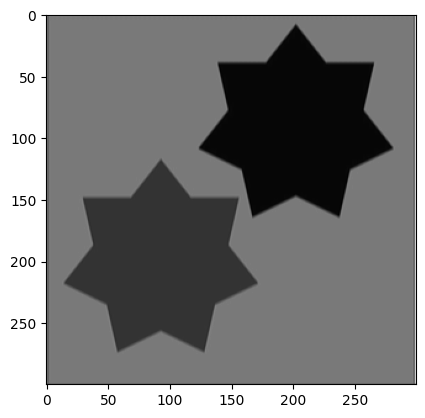

In [39]:
plt.imshow(filter_outputs[:,:,0],cmap='gray') # Print out the convolved result of the first filter

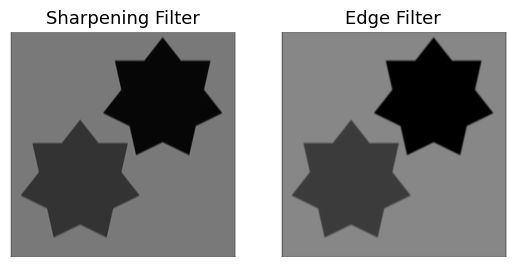

In [40]:
# Display the filter outputs
names = ["Sharpening Filter", "Edge Filter"]
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(filter_outputs[:,:,i], cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]}", fontsize=13)

From the two outputs, we notice that they produce very similar results, which is reasonable considering how simple the shape edges are.


## Deeper CNNs


In the last lab, you had a preview of multi-layered CNNs. Now with a better understanding of the relationship between input and output size, we can decipher where the output shapes of each layer come from when training the network.


### Why do we want multiple layers?


The benefit of multiple layers is that each layer can be responsible for detecting a certain set of features, which will help train the model better than if we only had a single layer. Moreover, we can specify different activation functions for each convolution layer. Let's see that in action with an example.


### Example: Preparing a CNN for Flower Classification


We will use our flower images from the image convolution lab. However, this time, we want to use them to train a CNN model for classification. Hence, we will utilize a training and test set.
[https://www.tensorflow.org/tutorials/load_data/images](https://www.tensorflow.org/tutorials/load_data/images?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)


In [41]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module3/L1/flower_photos.tgz"
data_dir = keras.utils.get_file(origin=dataset_url,
                                fname='flower_photos',
                                untar=True)

data_dir = pathlib.Path(data_dir)

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The roses folder has 641 pictures
The sunflowers folder has 699 pictures
The daisy folder has 633 pictures
The dandelion folder has 898 pictures
The tulips folder has 799 pictures
3670 total images


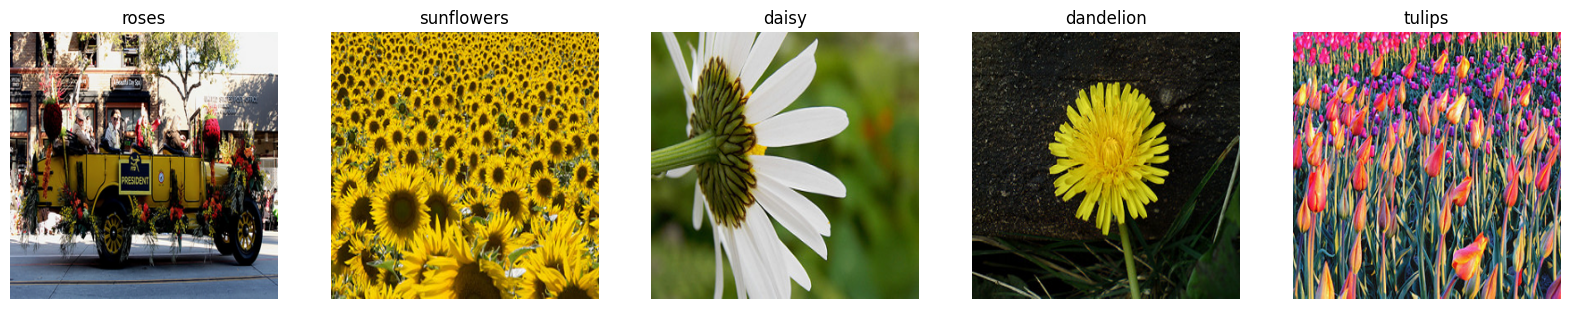

In [42]:
pics = list()
pics_arr = list()
p_class = list()

img_width = 300
img_height = 300

plt.figure(figsize=(20,5))
for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    cat = list(data_dir.glob(folder.name + '/*'))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1,5,idx+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)


#### Exercise: Define the model and add the first layer

Define the Sequential model and add the following layer to our classifier:

1.  Convolutional layer with 3 input channels, three 3x3 filters, even padding, and relu activation function.


In [43]:
# WRITE YOUR CODE HERE
classifier = Sequential()
classifier.add(Conv2D(3, (3, 3), padding='same', input_shape = (img_width, img_height, 3), activation = 'relu'))


<details><summary>Solution</summary>
    <code>classifier.add(Conv2D(3, (3, 3), padding='same', input_shape = (img_width, img_height, 3), activation = 'relu'))</code></br>
</details>


#### Exercise: Add additional layers

In Keras, you can simply call `add()` to add multiple layers to the Sequential model you've defined.

1.  Convolutional layer with two 3x3 filters and sigmoid activation function.
2.  Convolutional layer with six 5x5 filters, stride = 4, even padding, and relu activation function.
3.  Max pooling layer with size 2x2.


In [44]:
# WRITE YOUR CODE HERE
classifier.add(Conv2D(2, (3, 3), activation='sigmoid'))
classifier.add(Conv2D(6, (5, 5), strides = 4, padding='same', activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))


<details><summary>Solution</summary>
    <code>classifier.add(Conv2D(2, (3, 3), activation='sigmoid'))</code></br>
    <code>classifier.add(Conv2D(6, (5, 5), strides = 4, padding='same', activation = 'relu'))</code></br>
    <code>classifier.add(MaxPooling2D(pool_size=(2, 2))) </code>
</details>


### Flattening


When we get here, we've almost finished constructing the CNN model! Flattening is the process of converting input into a 1D array for the next layer. The reason behind this is that our final task - classification - isn't compatible with higher dimensional input, considering we desire a class label as output.

The way that tensors are flattened is quite simple. We desire an output of the shape Nx1, where N is the number of features in the input. For 2-dimensional input, this is straightforward - a tensor of the shape 28x28 will flatten into a single vector of 784x1.

What happens when the input has multiple channels? The shape is calculated in a similar way; that is, a 28x28x3 3D tensor would flatten to be 2352x1. Each channel is flattened first and then lined up along a single axis.


In [45]:
# Add a flattening layer
classifier.add(Flatten())

In [46]:
classifier.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 300, 300, 3)       84        
                                                                 
 conv2d_9 (Conv2D)           (None, 298, 298, 2)       56        
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 6)         306       
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 6)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8214)              0         
                                                                 
Total params: 446 (1.74 KB)
Trainable params: 446 (1.74 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

From the summary above, we see that the shape of the input (the output of the previous layer) is 37x37x6. The shape of the flattening layer output is 8214x1 = 37\*37\*6, demonstrating that the process was successful.


### Dense Layers


Before we start making predictions, there's one last layer(s) in the neural network - dense layers. The first fully connected layer essentially uses the features we learned from previous convolutional and pooling layers to make predictions for a given image. It takes a flattened 1D array as input, calculates their weighted average, and then applies an activation function on it. As a result, each output is a combination of all the input features, making this layer "fully-connected".

The last dense layer must have the softmax activation function when we have more than two classes because it will output probabilities of each label class and select the one with the highest probability as the final class of the input image.


Let's add two dense layers: one to connect with the flattened layer and the other to prepare the tensor for classification. Note that `units=5` for the second one because we have 5 categories of flowers total.


In [47]:
classifier.add(Dense(units = 512, activation = 'relu'))

classifier.add(Dense(units = 5, activation = 'softmax'))

In [48]:
classifier.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 300, 300, 3)       84        
                                                                 
 conv2d_9 (Conv2D)           (None, 298, 298, 2)       56        
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 6)         306       
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 6)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8214)              0         
                                                                 
 dense (Dense)               (None, 512)               4206080   
                                                      

That wraps up this lab! Knowing all the components of a convolutional neural network, you're now ready to use it for advanced applications - classification, object detection, and more. We'll specifically go into how to train your model for a classification task in the next lab.


## Authors


[Cindy Huang](https://www.linkedin.com/in/cindy-shih-ting-huang/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) is an incoming 4th year undergraduate at the University of Toronto studying data science. She has a passion for using machine learning to improve user experience.


### Other Contributors


[Joseph Santarcangelo](https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description |            |     |            |               |
| ----------------- | ------- | ---------- | ------------------ | ---------- | --- | ---------- | ------------- |
| 2022-06-13        | 0.1     | Cindy      | Create first draft |            |     |            |               |
| 2022-06-29        | 0.2     | Joseph     | Edited lab         | 2022-09-07 | 0.2 | Steve Hord | QA pass edits |


Copyright © 2022 IBM Corporation. All rights reserved.
